In [118]:
import cartopy
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt

from pathlib import Path
from geopy.geocoders import GoogleV3 

In [119]:
column_names = {
    "Region": "region", "State": "state", "Sector": "sector", "Station Type": "station_type", 
    "Station": "station", "Unit": "unit", "Date": "date", "Outage Type": "outage_type", 
    "Monitored CAP in MW": "monitored_capacity", "Generation / Today's Program": "generation_target", 
    "Generation / Today's Actual": "generation_achieved", "Generation / FY YTD Program": "generation_ytd_target", 
    "Generation / FY YTD Actual": "generation_ytd_achieved", "Coal Stock in Days": "coal_stock", 
    "CAP under outage": "outage_capacity", "Outage Date": "outage_date", "Expected Date / Sync Date": "expected_date",
    "Remarks": "outage_remarks"
} 

locator = GoogleV3("--enter-google-maps-api-key--")
def get_location(row: pd.Series) -> tuple[float, float]: 
    station_name: str = row["station"]
    if " ccpp" in station_name:
        station_name = station_name.replace("ccpp", "combined cycle power project")
    elif " stpp" in station_name:
        station_name = station_name.replace("stpp", "super thermal power project")
    elif " stps" in station_name:
        station_name = station_name.replace("stps", "super thermal power station")
    elif " tps" in station_name:
        station_name = station_name.replace("tps", "thermal power station")
    elif " tpp" in station_name:
        station_name = station_name.replace("tpp", "thermal power plant")

    location = locator.geocode((station_name + f", {row["state"]}").title())
    if location is not None:
        return location.latitude, location.longitude
    else:
        return np.nan, np.nan

unit_df = (
    pd.read_csv(Path.cwd() / "data" / "unit.csv")
    .rename(columns=column_names)
    .drop(columns=["generation_ytd_achieved", "generation_ytd_target", "coal_stock", "expected_date"])
    .assign(region=lambda df: df["region"].str.lower().astype("string"))
    .assign(state=lambda df: df["state"].str.lower().astype("string"))
    .assign(sector=lambda df: df["sector"].str.lower().astype("string"))
    .assign(station_type=lambda df: df["station_type"].str.lower().astype("string"))
    .assign(station=lambda df: df["station"].str.lower().astype("string"))
    .assign(unit=lambda df: df["unit"].str.removeprefix("Unit ").astype(int))
    .assign(date=lambda df: pd.to_datetime(df["date"]))
    .assign(outage_date=lambda df: pd.to_datetime(df["outage_date"]))
    .assign(outage_remarks=lambda df: df["outage_remarks"].str.lower().astype("string"))
)

station_locations_df = (
    pd.read_csv("data/station_locations.csv", index_col=0)
    .assign(latitude = lambda df: df["0"].apply(lambda x: x.split(",")[0].removeprefix("(")))
    .assign(longitude = lambda df: df["0"].apply(lambda x: x.split(",")[1].removesuffix(")")))
    .drop(columns="0")
)

stations_df = pd.concat([
    (
        unit_df
        .groupby(["station", "station_type", "sector", "state", "region", "unit"]).agg({"monitored_capacity": "max", "outage_type": "count", "date": "min"}).reset_index()
        .groupby(["station", "station_type", "sector", "state", "region"]).agg({"unit": "count", "monitored_capacity": "sum", "outage_type": "sum", "date": "min"})
        .rename(columns={"unit": "units", "outage_type": "outages"})
        .reset_index()
    ), 
    station_locations_df
], axis=1)

stations = stations_df["station"].to_list()
unit_df = (
    unit_df
    .assign(station = lambda df: df["station"].apply(lambda s: stations.index(s)))
    .drop(columns=["region", "state", "sector", "station_type", "monitored_capacity"])
)
outage_df = (
    unit_df[unit_df["outage_type"].notna()]
    .copy(deep=True)
)
generation_df = (
    unit_df[unit_df["outage_type"].isna()]
    .drop(columns=["outage_type", "outage_capacity", "outage_date", "outage_remarks"])
)

In [151]:
generation_df

,station,unit,date,generation_target,generation_achieved
27,48,1,2020-11-17,4.67,5.02
28,48,2,2020-11-17,4.70,4.77
29,48,3,2020-11-17,4.50,4.65
30,48,4,2020-11-17,4.50,4.62
31,48,5,2020-11-17,12.20,12.55
...,...,...,...,...,...
1404706,180,1,2022-07-15,9.74,9.31
1404707,180,2,2022-07-15,12.10,8.86
1404708,40,1,2022-07-15,3.58,4.59
1404709,40,2,2022-07-15,3.35,4.76


In [120]:
from pyproj import Transformer
affine = Transformer.from_crs("EPSG:4326", "EPSG:3857")
#stations_df[["longitude", "latitude"]] = stations_df.apply(lambda row: affine(row["longitude"], row["latitude"]))

,station,station_type,sector,state,region,units,monitored_capacity,outages,date,latitude,longitude
0,adani power limited kawai tpp,thermal,pvt sector,rajasthan,northern,2,1320.0,11,2023-09-20,27.0238036,74.21793260000001
1,adani power limited mundra tpp,thermal,pvt sector,gujarat,western,9,4620.0,2,2023-09-20,22.8241653,69.54902299999999
2,adani power limited mundra tpp - i & ii,thermal,pvt sector,gujarat,western,6,2640.0,75,2023-09-21,22.8241653,69.54902299999999
3,adani power limited mundra tpp - iii,thermal,pvt sector,gujarat,western,3,1980.0,58,2023-09-21,22.8241653,69.54902299999999
4,adani power limited raigarh tpp,thermal,pvt sector,chhatisgarh,western,1,600.0,8,2023-09-20,21.7412665,83.2746836
...,...,...,...,...,...,...,...,...,...,...,...
264,wanakbori tps,thermal,state sector,gujarat,western,8,2270.0,5829,2018-03-31,22.8671953,73.3517114
265,wardha warora tpp,thermal,pvt sector,maharashtra,western,4,540.0,4073,2018-03-31,20.250596,79.0163018
266,yadadri tps,thermal,state sector,telangana,southern,3,0.0,0,2022-02-14,16.6970997,79.58755459999999
267,yamuna nagar tps,thermal,state sector,haryana,northern,2,600.0,1217,2018-03-31,30.1290485,77.2673901


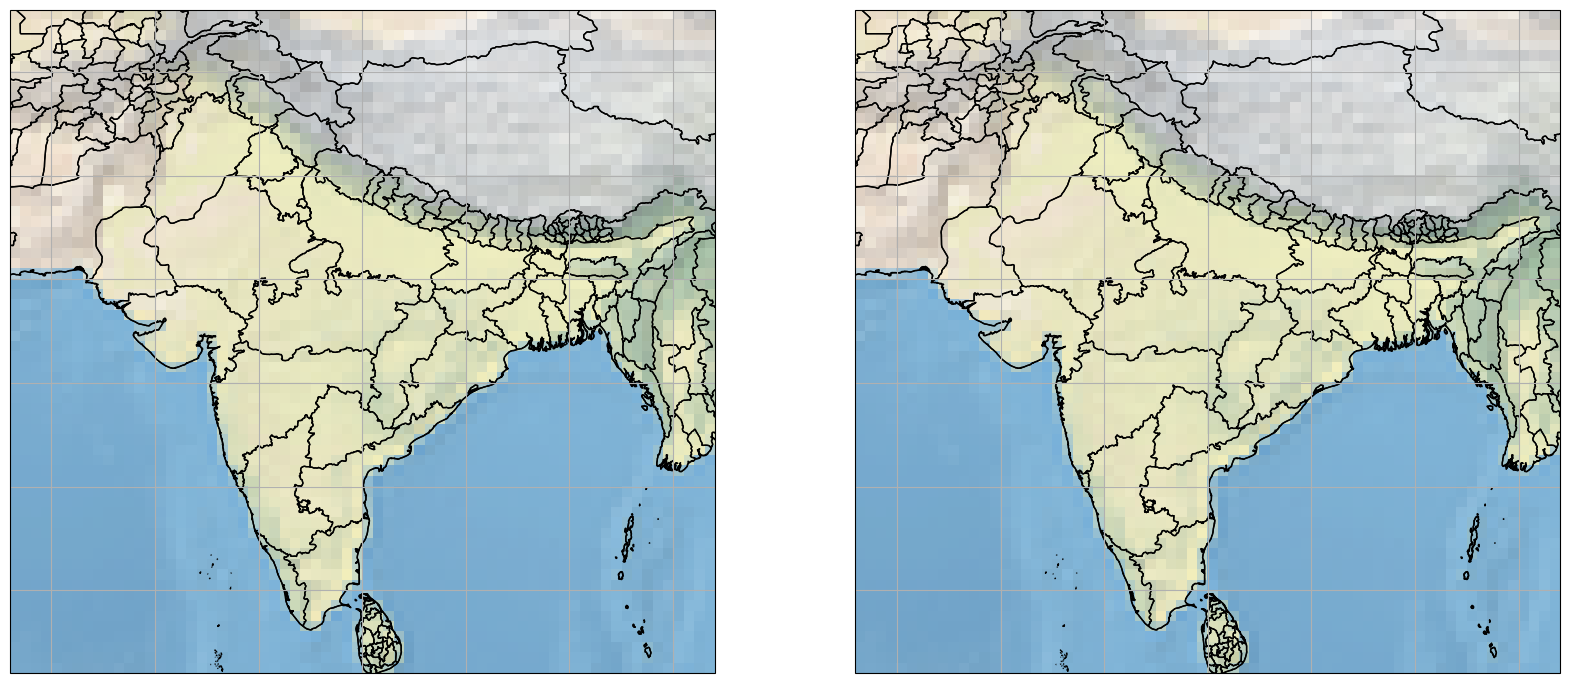

In [129]:
display(stations_df)

fig = plt.figure(figsize=(20, 10))
ax0 = fig.add_subplot(121, projection = cartopy.crs.PlateCarree())
ax0.stock_img()
ax0.coastlines()
ax0.gridlines()
ax0.set_extent([63, 97, 6, 38], crs = cartopy.crs.PlateCarree())
ax0.add_feature(cartopy.feature.STATES.with_scale('10m'))
ax0.scatter(x = stations_df["longitude"], y = stations_df["latitude"], s = stations_df["monitored_capacity"] / 100, transform = cartopy.crs.PlateCarree(), alpha = .7, color = "blue")

ax1 = fig.add_subplot(122, projection = cartopy.crs.PlateCarree())
ax1.stock_img()
ax1.coastlines()
ax1.gridlines()
ax1.set_extent([63, 97, 6, 38], crs = cartopy.crs.PlateCarree())
ax1.add_feature(cartopy.feature.STATES.with_scale('10m'))
ax1.scatter(x = stations_df["longitude"], y = stations_df["latitude"], s = stations_df["outages"], transform = cartopy.crs.PlateCarree(), alpha = .7, color = "red")

plt.show()

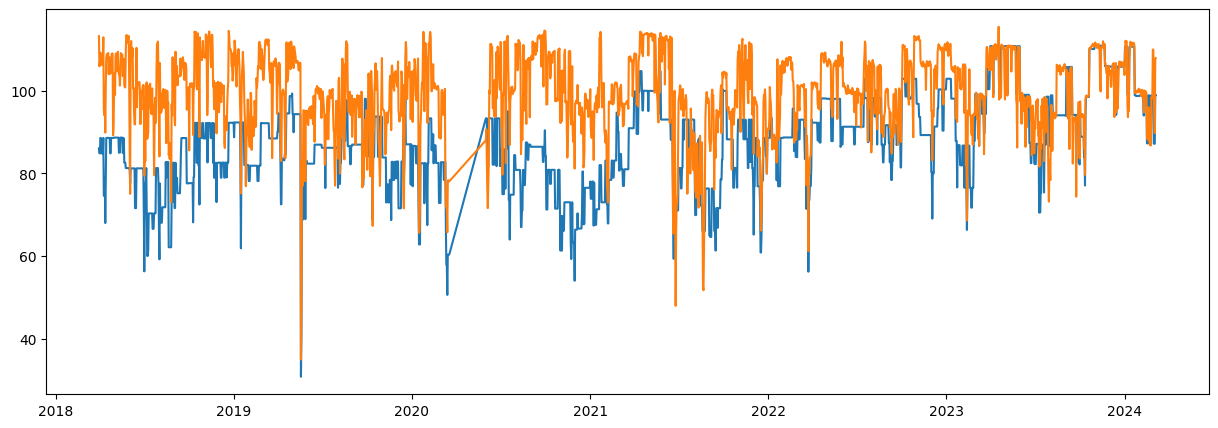

In [146]:
fig, ax = plt.subplots(1,1, figsize = (15, 5))
df = generation_df[generation_df["station"] == 261].groupby(["station", "date"]).sum()
df = df.drop(columns="unit").reset_index()
df
ax.plot(df["date"], df["generation_target"])
ax.plot(df["date"], df["generation_achieved"])

In [ ]:
# Thermal Power Plant
# Combined Cycle Power Plant
# Super Thermal Power Project

# > Bubblemap using locations and avg generation per year
# > Scatter Plots Showing Programmed vs Actual Power Generation, w/ x=y graph
# > Bubblemap using locations and number of outages per sate, outages per sector, reasons for outages, timeline for outages